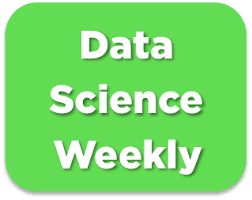

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, classification_report, 
                             precision_recall_curve, auc, RocCurveDisplay, PrecisionRecallDisplay)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "svg"
from plotly.subplots import make_subplots
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
import plotly.figure_factory as ff

# Read file with labels

In [2]:
data = pd.read_csv(r"src\conversion_data_train.csv")
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [3]:
data.head()

country  age  new_user  source  total_pages_visited  converted
0    China   22         1  Direct                    2          0
1       UK   21         1     Ads                    3          0
2  Germany   20         0     Seo                   14          1
3       US   23         1     Seo                    3          0
4       US   28         1  Direct                    3          0

# Explore dataset

In [6]:
# statistiques de base
data.describe(include="all")

country            age       new_user  source  total_pages_visited  \
count   284580  284580.000000  284580.000000  284580        284580.000000   
unique       4            NaN            NaN       3                  NaN   
top         US            NaN            NaN     Seo                  NaN   
freq    160124            NaN            NaN  139477                  NaN   
mean       NaN      30.564203       0.685452     NaN             4.873252   
std        NaN       8.266789       0.464336     NaN             3.341995   
min        NaN      17.000000       0.000000     NaN             1.000000   
25%        NaN      24.000000       0.000000     NaN             2.000000   
50%        NaN      30.000000       1.000000     NaN             4.000000   
75%        NaN      36.000000       1.000000     NaN             7.000000   
max        NaN     123.000000       1.000000     NaN            29.000000   

            converted  
count   284580.000000  
unique            NaN  
top               NaN  
freq              NaN  
mean         0.032258  
std          0.176685  
min          0.000000  
25%          0.000000  
50%          0.000000  
75%          0.000000  
max          1.000000

In [3]:
# Suppression des âges supérieur à 80 ans
data = data[data['age'] < 80]

In [4]:
data.shape

(284578, 6)

In [4]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = data.sample(10000)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 284578 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284578 non-null  object
 1   age                  284578 non-null  int64 
 2   new_user             284578 non-null  int64 
 3   source               284578 non-null  object
 4   total_pages_visited  284578 non-null  int64 
 5   converted            284578 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 15.2+ MB


In [5]:
# Changement de type de colonnes
data_sample['converted'] = data_sample['converted'].astype(bool)
data_sample['new_user'] = data_sample['new_user'].astype(bool)

In [10]:
# Nombre de valeurs manquantes
data.isna().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

In [11]:
# Nombre de doublons
data.duplicated().sum()

np.int64(268769)

Ces doublons correspondent à presque tout le dataset. Il est tout à fait possible que plusieurs utilisateurs aient le même profil. Je les conserve.

### Variable cible : converted

In [3]:
data['converted'].value_counts()

converted
0    275400
1      9180
Name: count, dtype: int64

In [19]:
data['converted'].value_counts(normalize=True)

converted
0    0.967749
1    0.032251
Name: proportion, dtype: float64

### Analyse univarié

In [6]:
var_num = ['age', 'total_pages_visited']

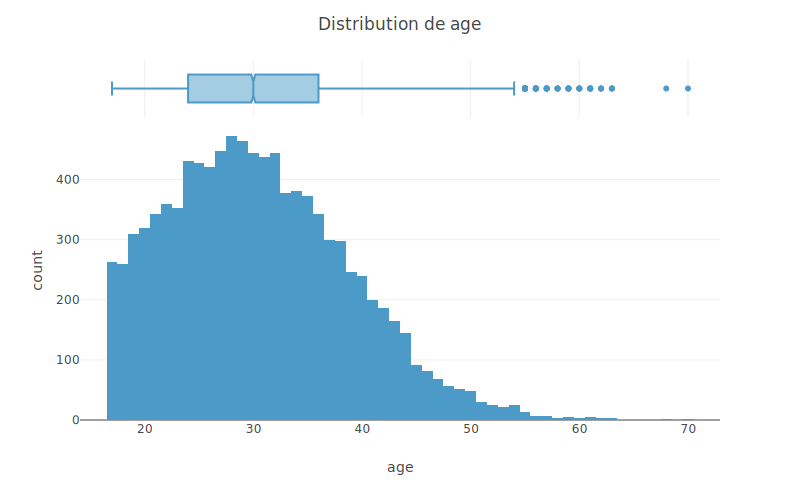

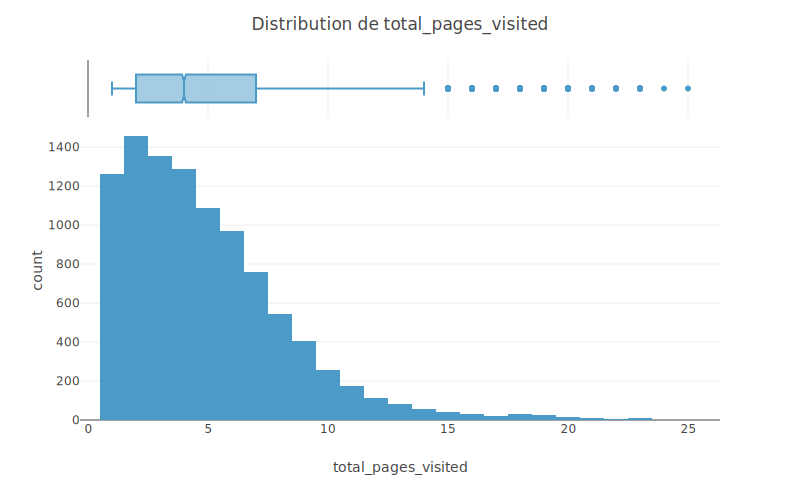

In [7]:
# Histogramme avec boxplot superposé
for column in var_num:
    fig = px.histogram(
        data_sample, x=column, 
        marginal="box",  # Ajoute un boxplot
    )

    fig.update_layout(
        title_text=f"Distribution de {column}",
        title_x=0.5,
        height=500,
        width=800
    )
    
    fig.show()

In [8]:
var_cat = ['country', 'new_user', 'source']

country : ['China' 'UK' 'Germany' 'US']


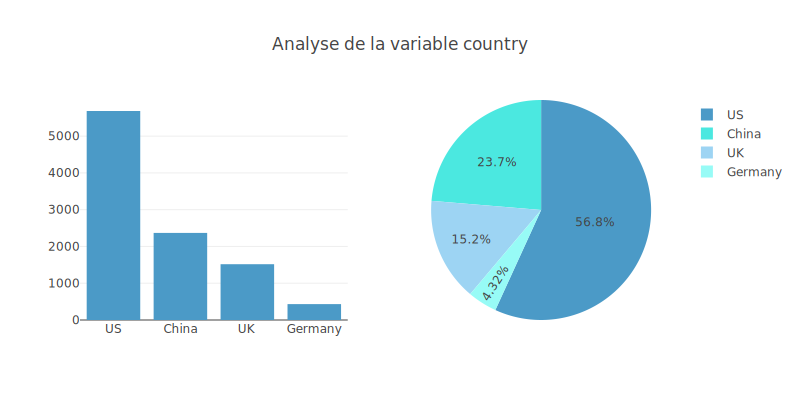

new_user : [1 0]


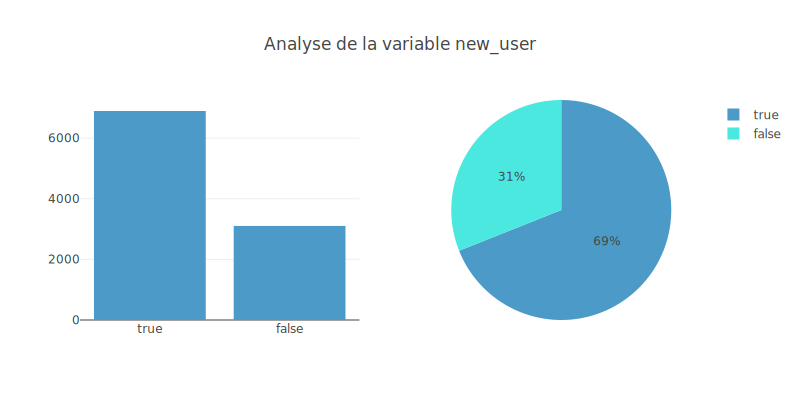

source : ['Direct' 'Ads' 'Seo']


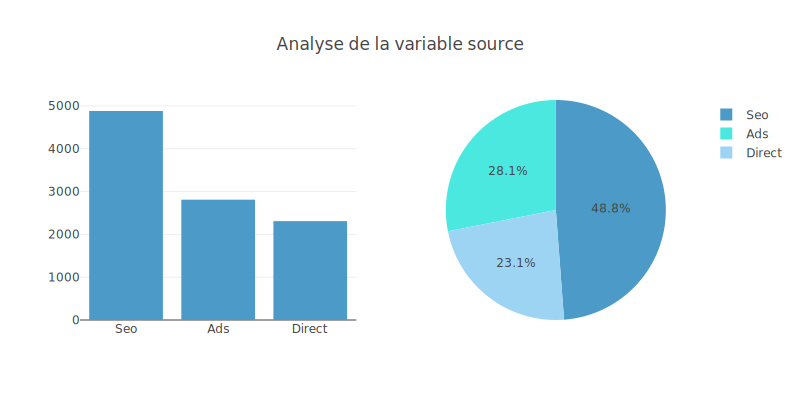

In [9]:
# Pie chart et graphique en barres pour chaque variable qualitative
for col in var_cat:
    # Valeurs uniques des variables catégoriques ou qualitatives
    print(f'{col} : {data[col].unique()}')
    

    fig = make_subplots(
        rows=1, cols=2, 
        specs=[[{"type": "xy"}, {"type": "domain"}, ]],  
    )
    
    # Bar plot
    bar_fig = px.bar(
        data_sample[col].value_counts().reset_index(),
        x=col,
        y="count",
        #labels={"index": column, column: "Nombre"},
        title=f"Distribution des catégories pour {col}"
    )
    
    # Pie chart
    pie_fig = px.pie(data_sample, names=col)

    # Ajout des traces de pie et bar
    for trace in bar_fig.data:
        fig.add_trace(trace, row=1, col=1)
    for trace in pie_fig.data:
        fig.add_trace(trace, row=1, col=2)
    
    # Mise à jour de la mise en page
    fig.update_layout(
        title_text=f"Analyse de la variable {col}",
        title_x=0.5,
        height=400,
        width=800
    )
    
    fig.show()

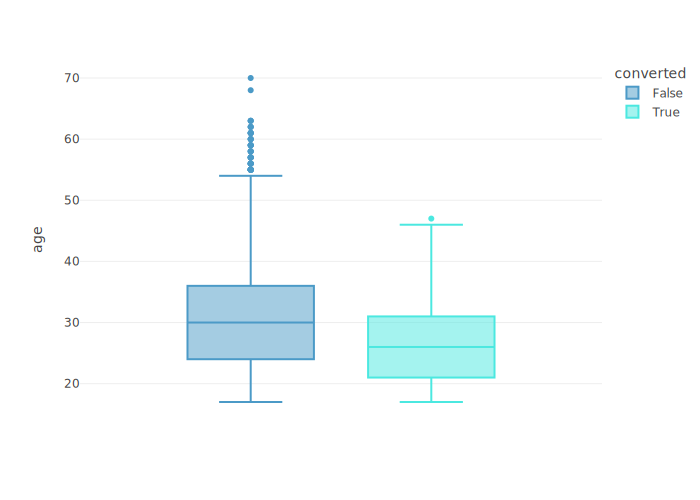

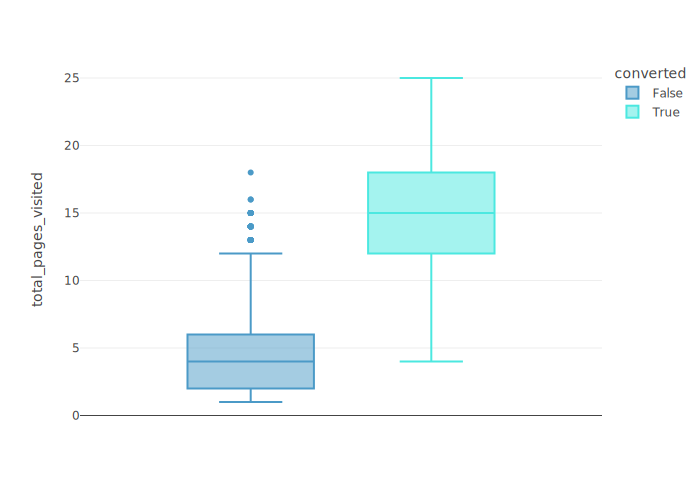

In [10]:
# Box plot des variables explicatives numériques en fonction de la variable cible
for col in var_num:
    fig = px.box( data_sample, y=col, color='converted')
    fig.show()

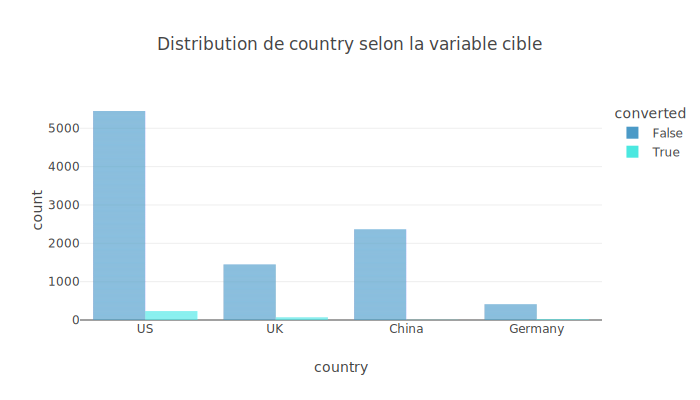

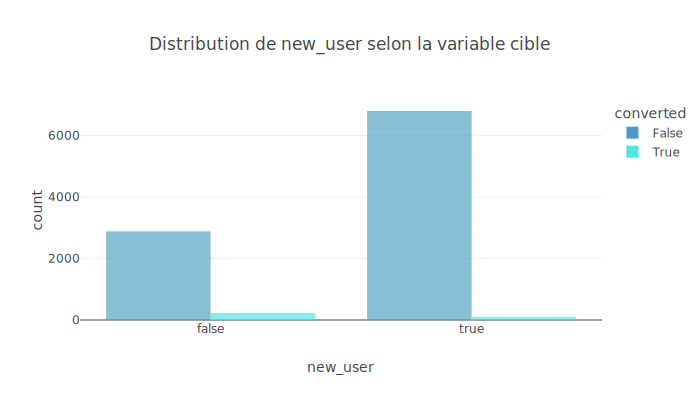

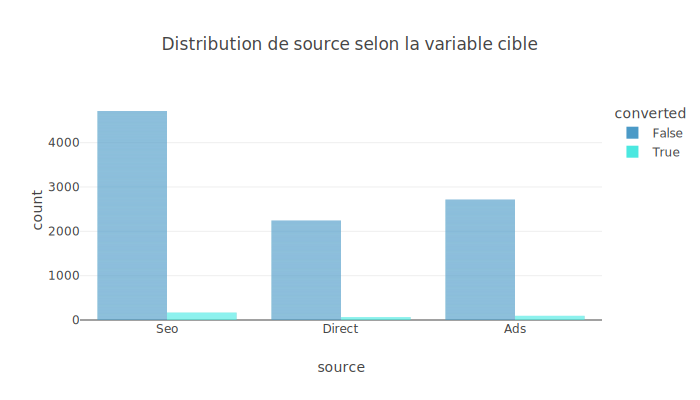

In [ ]:
# Variable catégorielle explicative en fonction de la variable cible
for col in var_cat:
    
    fig = px.bar(
        data_sample, 
        x=col, 
        color='converted',  
        barmode="group",    
        title=f"Distribution de {col} selon la variable cible"
    )

    fig.update_layout(
        title_x=0.5,              
        height=400,
        width=700
    )
    
    fig.show()


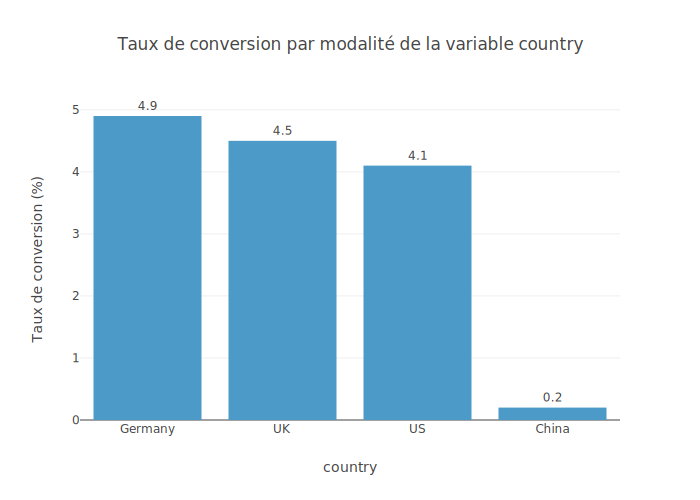

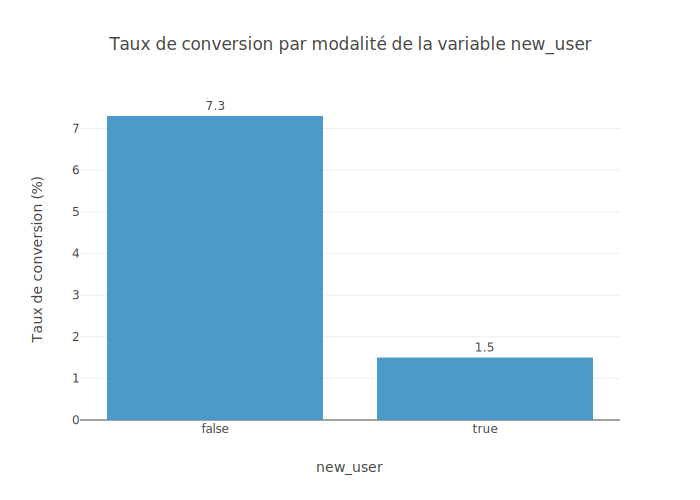

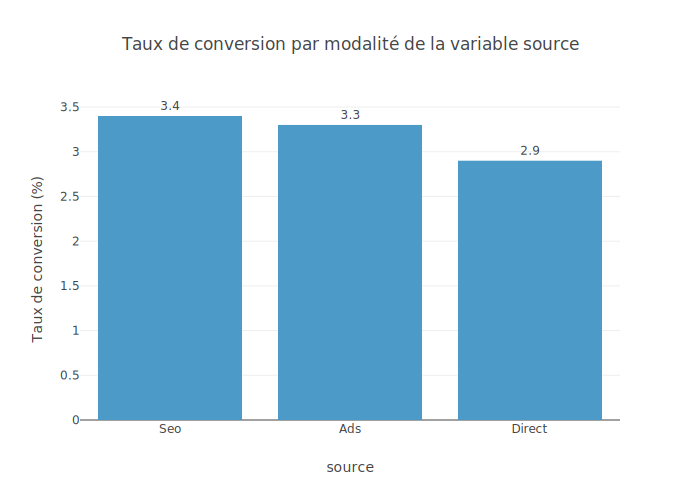

In [ ]:
# Taux de conversion en fonction des modalités des variables catégoriques
for col in var_cat:
    # Calcul du pourcentage de conversion pour chaque catégories de col
    data_converted = (data_sample.groupby(col)['converted'].agg('mean').mul(100).round(1)
                      .reset_index(name='taux_conversion')
                      .sort_values(by='taux_conversion', ascending=False))

    fig = px.bar(
        data_converted,
        x=col,
        y='taux_conversion',
        text='taux_conversion',
        labels={col: col, 'taux_conversion': 'Taux de conversion (%)'},
        title=f"Taux de conversion par modalité de la variable {col}"
    )

    fig.update_traces(textposition='outside')
    fig.update_layout(height=500, width=700)

    fig.show()

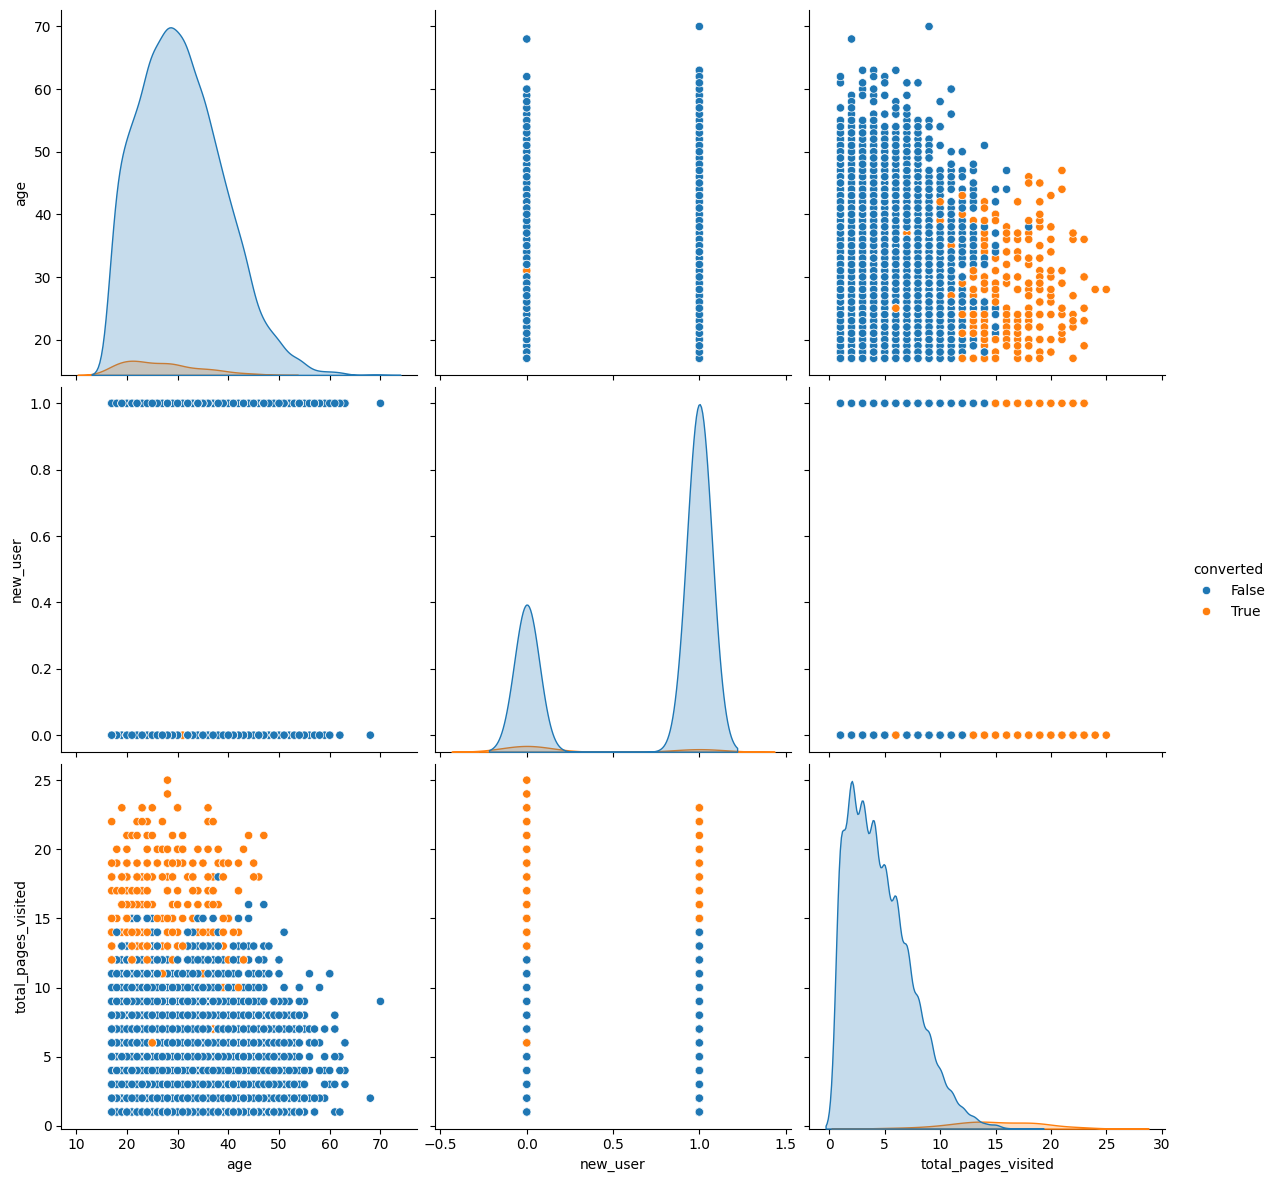

In [14]:
sns.pairplot(data_sample, hue='converted', height=4)

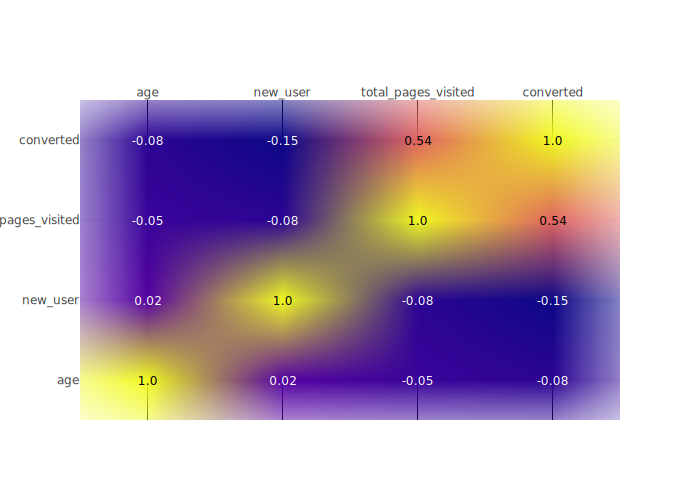

In [ ]:
# Correlation matrix
corr = data_sample.select_dtypes(['number', 'bool']).corr().round(2)

fig = ff.create_annotated_heatmap(corr.values,
                                  x = corr.columns.tolist(),
                                  y = corr.index.tolist())
fig.show()

# Make your model

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [16]:
features_list = ['total_pages_visited']
numeric_indices = [0]
categorical_indices = []
target_variable = 'converted'

In [17]:
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['total_pages_visited'], dtype='object')



In [18]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



## Training pipeline

In [19]:
# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")

featureencoder = StandardScaler()
X_train = featureencoder.fit_transform(X_train)
print("...Done")
print(X_train[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 0.33742062]
 [ 0.03809786]
 [-0.85987044]
 [ 0.33742062]
 [-0.26122491]]


In [20]:
# Train model
print("Train model...")
classifier = LogisticRegression() 
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [21]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



## Test pipeline

In [22]:
# Use X_test, and the same preprocessings as in training pipeline, 
# but call "transform()" instead of "fit_transform" methods (see example below)

print("Encoding categorical features and standardizing numerical features...")

X_test = featureencoder.transform(X_test)
print("...Done")
print(X_test[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 0.63674339]
 [-0.85987044]
 [-1.15919321]
 [-0.85987044]
 [ 0.93606615]]


In [23]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



## Performance assessment

In [24]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.6957985550957424
f1-score on test set :  0.6893203883495146


In [25]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[246823   1077]
 [  3260   4960]]

Confusion matrix on test set : 
[[27378   122]
 [  390   568]]



**Our baseline model reaches a f1-score of almost 70%. Now, feel free to refine your model and try to beat this score ! 🚀🚀**

## Preprocessing

In [5]:
# Drop outliers from age avec la méthode IQR
Q1 = data['age'].quantile(0.25)
Q3 = data['age'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR
print(upper_bound)

data = data[data['age'] <= upper_bound ]

54.0


In [6]:
data.shape

(283211, 6)

In [7]:
# Séparation des variables explicatives de la variable cible
X = data[[ 'country', 'age', 'new_user', 'source', 'total_pages_visited']]
y = data["converted"]

# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [8]:
num_features = ['age', 'total_pages_visited']
cat_features = ['country', 'source']
passthrough_features = ['new_user']

# Pipeline pour les colonnes numériques
num_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

# Pipeline pour les colonnes catégoriques
cat_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(drop="first")) 
])

# Preprocessing
preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features),
    ("pass", "passthrough", passthrough_features)  
])

# Preprocessing sur le set de train et de test
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Nom des colonnes transformées
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['num__age', 'num__total_pages_visited', 'cat__country_Germany',
       'cat__country_UK', 'cat__country_US', 'cat__source_Direct',
       'cat__source_Seo', 'pass__new_user'], dtype=object)

## LogisticRegression

In [9]:
lr_model = LogisticRegression() 
lr_model.fit(X_train, y_train)

LogisticRegression()

In [10]:
# Prédictions
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

# Proba de prédiction de la classe positive
y_train_proba = lr_model.predict_proba(X_train)[:, 1] 
y_test_proba = lr_model.predict_proba(X_test)[:, 1] 

# Performance sur l'ensemble d'entraînement
print("Train Accuracy :", accuracy_score(y_train, y_train_pred))
print("Train F1 : ", f1_score(y_train, y_train_pred))
print("Confusion Matrix (Train) :\n", confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))
print()

# Performance sur l'ensemble de test
print("Test Accuracy :", accuracy_score(y_test, y_test_pred))
print("Test F1 : ", f1_score(y_test, y_test_pred))
print("Confusion Matrix (Test) :\n", confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Train Accuracy : 0.9861272946262883
Train F1 :  0.7626527050610821
Confusion Matrix (Train) :
 [[245672    964]
 [  2572   5681]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    246636
           1       0.85      0.69      0.76      8253

    accuracy                           0.99    254889
   macro avg       0.92      0.84      0.88    254889
weighted avg       0.99      0.99      0.99    254889


Test Accuracy : 0.986406327236777
Test F1 :  0.7662416514875531
Confusion Matrix (Test) :
 [[27306    99]
 [  286   631]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27405
           1       0.86      0.69      0.77       917

    accuracy                           0.99     28322
   macro avg       0.93      0.84      0.88     28322
weighted avg       0.99      0.99      0.99     28322



In [12]:
# GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'l1_ratio': [0, 0.1, 0.5, 0.9, 1],   
    'class_weight' : [None, 'balanced']
}

grid_search = GridSearchCV(
    LogisticRegression(penalty='elasticnet', solver='saga', max_iter=1000), 
    param_grid, cv=5, 
    scoring='f1', 
    verbose=3, n_jobs=-1)

grid_search.fit(X_train, y_train)

# Meilleurs paramètres
print()
print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("Meilleur score F1 :", grid_search.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits

Meilleurs hyperparamètres : {'C': 10, 'class_weight': None, 'l1_ratio': 0}
Meilleur score F1 : 0.764014832179463


In [13]:
# Meilleur modèle
best_model_lr = grid_search.best_estimator_

# Prédictions
y_train_pred = best_model_lr.predict(X_train)
y_test_pred = best_model_lr.predict(X_test)

# Probabilité de prédiction de la classe positive
y_train_proba = best_model_lr.predict_proba(X_train)[:, 1]  
y_test_proba = best_model_lr.predict_proba(X_test)[:, 1]  

# Performance sur l'ensemble d'entraînement
print("Train Accuracy :", accuracy_score(y_train, y_train_pred))
print("Train F1 : ", f1_score(y_train, y_train_pred))
print("Confusion Matrix (Train) :\n", confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))
print()

# Performance sur l'ensemble de test
print("Test Accuracy :", accuracy_score(y_test, y_test_pred))
print("Test F1 : ", f1_score(y_test, y_test_pred))
print("Confusion Matrix (Test) :\n", confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Train Accuracy : 0.9861429877319147
Train F1 :  0.7633342267488609
Confusion Matrix (Train) :
 [[245661    975]
 [  2557   5696]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    246636
           1       0.85      0.69      0.76      8253

    accuracy                           0.99    254889
   macro avg       0.92      0.84      0.88    254889
weighted avg       0.99      0.99      0.99    254889


Test Accuracy : 0.986406327236777
Test F1 :  0.7665251667677381
Confusion Matrix (Test) :
 [[27305   100]
 [  285   632]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27405
           1       0.86      0.69      0.77       917

    accuracy                           0.99     28322
   macro avg       0.93      0.84      0.88     28322
weighted avg       0.99      0.99      0.99     28322



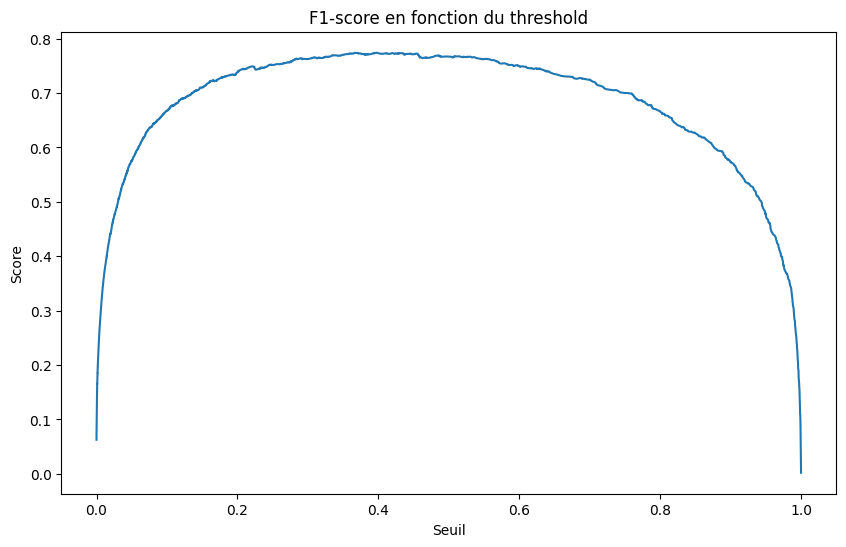

Le seuil optimal pour maximiser le F1-score est : 0.40


In [14]:
# Probabilités de prédiction d'appartenance à la classe positive
y_scores_test = best_model_lr.predict_proba(X_test)[:, 1]

# Precision, recall , seuils
precision, recall, thresholds = precision_recall_curve(y_test, y_scores_test)

# Calcul du F1-score pour chaque seuil
f1_scores = 2 * (precision * recall) / (precision + recall)

# Courbe F1-score en fonction du threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores[:-1], label="F1-score")
plt.xlabel("Seuil")
plt.ylabel("Score")
plt.title("F1-score en fonction du threshold")
plt.show()

# Indice du seuil qui maximise la F1-score
optimal_idx = np.argmax(f1_scores)

# Seuil optimal qui maximise F1-score
optimal_threshold = thresholds[optimal_idx]

print(f"Le seuil optimal pour maximiser le F1-score est : {optimal_threshold:.2f}")

In [15]:
threshold = optimal_threshold

# Prédiction sur les données d'entraînement
y_train_proba = best_model_lr.predict_proba(X_train)[:, 1]
y_train_pred = (y_train_proba >= threshold).astype(int)

# Prédiction sur les données de test
y_test_proba = best_model_lr.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= threshold).astype(int)


# Performance sur l'ensemble d'entraînement
print("Train Accuracy :", accuracy_score(y_train, y_train_pred))
print("Train F1 : ", f1_score(y_train, y_train_pred))
print("Confusion Matrix (Train) :\n", confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))
print()

# Performance sur l'ensemble de test
print("Test Accuracy :", accuracy_score(y_test, y_test_pred))
print("Test F1 : ", f1_score(y_test, y_test_pred))
print("Confusion Matrix (Test) :\n", confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Train Accuracy : 0.9857467368148488
Train F1 :  0.7701069417199266
Confusion Matrix (Train) :
 [[245171   1465]
 [  2168   6085]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    246636
           1       0.81      0.74      0.77      8253

    accuracy                           0.99    254889
   macro avg       0.90      0.87      0.88    254889
weighted avg       0.99      0.99      0.99    254889


Test Accuracy : 0.9861238613092296
Test F1 :  0.7740080506037953
Confusion Matrix (Test) :
 [[27256   149]
 [  244   673]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     27405
           1       0.82      0.73      0.77       917

    accuracy                           0.99     28322
   macro avg       0.90      0.86      0.88     28322
weighted avg       0.99      0.99      0.99     28322



In [ ]:
# feature_importance
feature_importance = pd.DataFrame(
    index=feature_names,
    data=best_model_lr.coef_[0],
    columns=["feature_importances"],
)
feature_importance = feature_importance.sort_values(by="feature_importances")
feature_importance

feature_importances
pass__new_user                      -1.753253
num__age                            -0.599943
cat__source_Direct                  -0.223953
cat__source_Seo                     -0.041759
num__total_pages_visited             2.542568
cat__country_US                      3.210402
cat__country_UK                      3.550402
cat__country_Germany                 3.739228

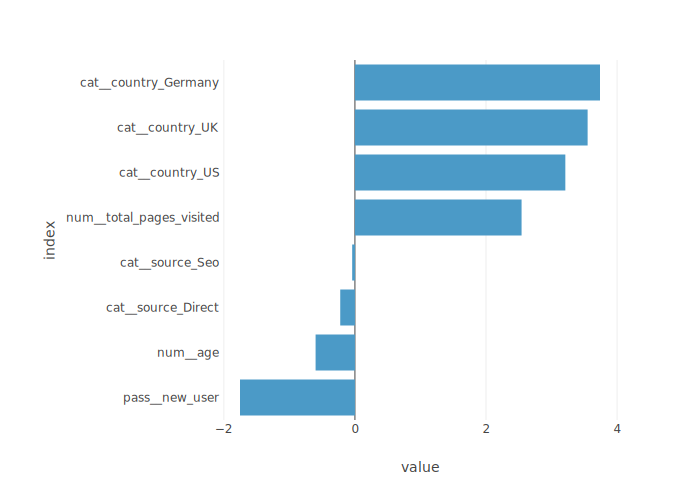

In [ ]:
# Plot de feature_importance
fig = px.bar(feature_importance, orientation="h")
fig.update_layout(
    showlegend=False, 
    margin={"l": 220}  
)
fig.show()

In [21]:
df_scores = pd.DataFrame([{
    'model': 'LogisticRegression',
    'f1': f1_score(y_test, y_test_pred)
}])

df_scores

model        f1
0  LogisticRegression  0.774008

## DecisionTreeClassifier

In [34]:
# Arbre de décision
tree_model = DecisionTreeClassifier() 
tree_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
# Prédiction
y_test_pred = tree_model.predict(X_test)
y_train_pred = tree_model.predict(X_train)

# Proba de prédiction de la classe positive
y_train_proba_tree = tree_model.predict_proba(X_train)[:, 1]  
y_test_proba_tree = tree_model.predict_proba(X_test)[:, 1]  

# Performance sur l'ensemble d'entraînement
print("Train Accuracy :", accuracy_score(y_train, y_train_pred))
print("Train F1 : ", f1_score(y_train, y_train_pred))
print("Confusion Matrix (Train) :\n", confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

print()

# Performance sur l'ensemble de test
print("Test Accuracy :", accuracy_score(y_test, y_test_pred))
print("Test F1 : ", f1_score(y_test, y_test_pred))
print("Confusion Matrix (Test) :\n", confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Train Accuracy : 0.9882615569914747
Train F1 :  0.796877121520706
Confusion Matrix (Train) :
 [[246028    608]
 [  2384   5869]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    246636
           1       0.91      0.71      0.80      8253

    accuracy                           0.99    254889
   macro avg       0.95      0.85      0.90    254889
weighted avg       0.99      0.99      0.99    254889


Test Accuracy : 0.9842172162982841
Test F1 :  0.7232198142414861
Confusion Matrix (Test) :
 [[27291   114]
 [  333   584]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27405
           1       0.84      0.64      0.72       917

    accuracy                           0.98     28322
   macro avg       0.91      0.82      0.86     28322
weighted avg       0.98      0.98      0.98     28322



In [36]:
# GridSearchCV
param_grid = {
    'max_depth' : [3, 5, 7, 9, 11],                     # profondeur maximale de l’arbre
    'criterion': ['gini', 'entropy'], 
    'min_samples_split': [2, 5, 10],                    # min d’échantillons pour diviser un noeud
    'min_samples_leaf': [1, 2, 4],                      # min d’échantillons dans une feuille
    'max_features': [None, 'sqrt', 'log2'] ,            # nombre de features testés à chaque split
    'class_weight' : [None, 'balanced']
}

grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, scoring='f1', verbose=3, n_jobs=-1)

grid_search.fit(X_train, y_train)

# Meilleurs paramètres
print()
print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("Meilleur score F1 :", grid_search.best_score_)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits

Meilleurs hyperparamètres : {'class_weight': None, 'criterion': 'entropy', 'max_depth': 9, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Meilleur score F1 : 0.7533539569946998


In [37]:
# Meilleur modèle
best_model_tree = grid_search.best_estimator_

# Prédiction
y_test_pred = best_model_tree.predict(X_test)
y_train_pred = best_model_tree.predict(X_train)

# Proba de prédiction de la classe positive
y_train_proba_tree = best_model_tree.predict_proba(X_train)[:, 1] 
y_test_proba_tree = best_model_tree.predict_proba(X_test)[:, 1]  

# Performance sur l'ensemble d'entraînement
print("Train Accuracy :", accuracy_score(y_train, y_train_pred))
print("Train F1 : ", f1_score(y_train, y_train_pred))
print("Confusion Matrix (Train) :\n", confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

# Performance sur l'ensemble de test
print("Test Accuracy :", accuracy_score(y_test, y_test_pred))
print("Test F1 : ", f1_score(y_test, y_test_pred))
print("Confusion Matrix (Test) :\n", confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Train Accuracy : 0.9862214532600465
Train F1 :  0.7665204095200107
Confusion Matrix (Train) :
 [[245612   1024]
 [  2488   5765]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    246636
           1       0.85      0.70      0.77      8253

    accuracy                           0.99    254889
   macro avg       0.92      0.85      0.88    254889
weighted avg       0.99      0.99      0.99    254889

Test Accuracy : 0.985029305839983
Test F1 :  0.7451923076923077
Confusion Matrix (Test) :
 [[27278   127]
 [  297   620]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27405
           1       0.83      0.68      0.75       917

    accuracy                           0.99     28322
   macro avg       0.91      0.84      0.87     28322
weighted avg       0.98      0.99      0.98     28322



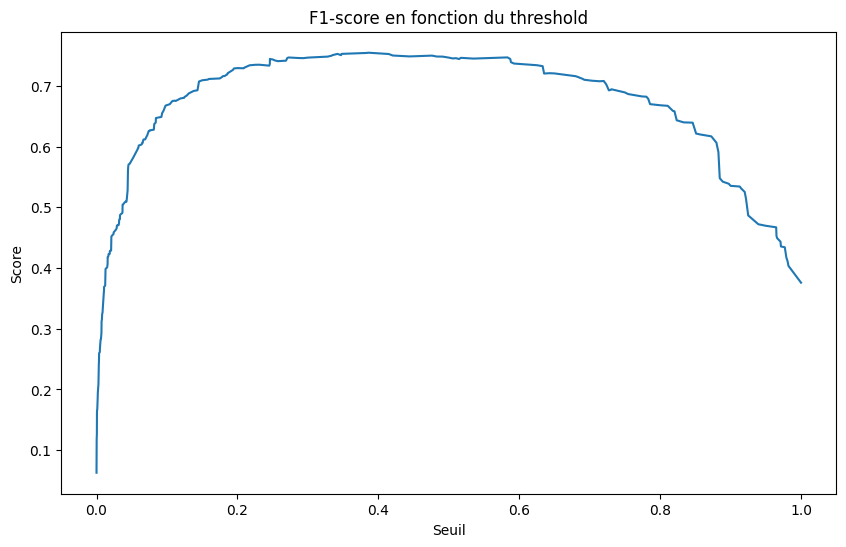

Le seuil optimal pour maximiser le F1-score est : 0.39


In [38]:
# Probabilités de prédiction d'appartenance à la classe positive
y_scores_test = best_model_tree.predict_proba(X_test)[:, 1]

# Precision, recall , seuils
precision, recall, thresholds = precision_recall_curve(y_test, y_scores_test)

# Calcul du F1-score pour chaque seuil
f1_scores = 2 * (precision * recall) / (precision + recall)

# Courbe F1-score en fonction du threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores[:-1], label="F1-score")
plt.xlabel("Seuil")
plt.ylabel("Score")
plt.title("F1-score en fonction du threshold")
plt.show()

# Indice du seuil qui maximise la F1-score
optimal_idx = np.argmax(f1_scores)

# Seuil optimal qui maximise F1-score
optimal_threshold = thresholds[optimal_idx]

print(f"Le seuil optimal pour maximiser le F1-score est : {optimal_threshold:.2f}")

In [39]:
threshold = optimal_threshold

# Prédiction sur les données d'entraînement
y_train_proba = best_model_tree.predict_proba(X_train)[:, 1]
y_train_pred = (y_train_proba >= threshold).astype(int)

# Prédiction sur les données de test
y_test_proba = best_model_tree.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= threshold).astype(int)


# Performance sur l'ensemble d'entraînement
print("Train Accuracy :", accuracy_score(y_train, y_train_pred))
print("Train F1 : ", f1_score(y_train, y_train_pred))
print("Confusion Matrix (Train) :\n", confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))
print()

# Performance sur l'ensemble de test
print("Test Accuracy :", accuracy_score(y_test, y_test_pred))
print("Test F1 : ", f1_score(y_test, y_test_pred))
print("Confusion Matrix (Test) :\n", confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Train Accuracy : 0.9857938161317279
Train F1 :  0.7711848341232227
Confusion Matrix (Train) :
 [[245166   1470]
 [  2151   6102]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    246636
           1       0.81      0.74      0.77      8253

    accuracy                           0.99    254889
   macro avg       0.90      0.87      0.88    254889
weighted avg       0.99      0.99      0.99    254889


Test Accuracy : 0.9849586893580962
Test F1 :  0.7546082949308756
Confusion Matrix (Test) :
 [[27241   164]
 [  262   655]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     27405
           1       0.80      0.71      0.75       917

    accuracy                           0.98     28322
   macro avg       0.90      0.85      0.87     28322
weighted avg       0.98      0.98      0.98     28322



In [40]:
# feature_importance
feature_importance = pd.DataFrame(
    index=feature_names,
    data=best_model_tree.feature_importances_,
    columns=["feature_importances"],
)
feature_importance = feature_importance.sort_values(by="feature_importances")
feature_importance

feature_importances
cat__source_Seo                      0.001057
cat__source_Direct                   0.001716
cat__country_UK                      0.007992
cat__country_US                      0.010045
cat__country_Germany                 0.010915
num__age                             0.028131
pass__new_user                       0.048044
num__total_pages_visited             0.892101

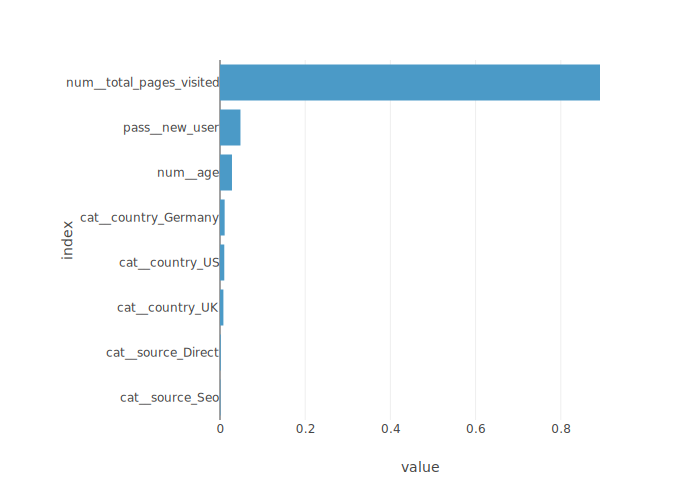

In [41]:
# Plot de feature_importance
fig = px.bar(feature_importance, orientation="h")
fig.update_layout(
    showlegend=False, 
    margin={"l": 220}  
)
fig.show()

In [42]:
score_tree = [{'model': 'DecisionTreeClassifier', 'f1': f1_score(y_test, y_test_pred)}]
df_scores = pd.concat([df_scores, pd.DataFrame(score_tree)], ignore_index=True)

df_scores

model        f1
0      LogisticRegression  0.774008
1  DecisionTreeClassifier  0.754608

## RandomForestClassifier

In [43]:
# Random Forest
rf_model = RandomForestClassifier() 
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [44]:
# Prédiction
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Proba de prédiction de la classe positive
y_train_proba_tree = rf_model.predict_proba(X_train)[:, 1]  
y_test_proba_tree = rf_model.predict_proba(X_test)[:, 1] 

# Performance sur l'ensemble d'entraînement
print("Train Accuracy :", accuracy_score(y_train, y_train_pred))
print("Train F1 : ", f1_score(y_train, y_train_pred))
print("Confusion Matrix (Train) :\n", confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))
print()

# Performance sur l'ensemble de test
print("Test Accuracy :", accuracy_score(y_test, y_test_pred))
print("Test F1 : ", f1_score(y_test, y_test_pred))
print("Confusion Matrix (Test) :\n", confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Train Accuracy : 0.9882615569914747
Train F1 :  0.8012752391073327
Confusion Matrix (Train) :
 [[245865    771]
 [  2221   6032]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    246636
           1       0.89      0.73      0.80      8253

    accuracy                           0.99    254889
   macro avg       0.94      0.86      0.90    254889
weighted avg       0.99      0.99      0.99    254889


Test Accuracy : 0.9849233811171527
Test F1 :  0.7423053711526856
Confusion Matrix (Test) :
 [[27280   125]
 [  302   615]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27405
           1       0.83      0.67      0.74       917

    accuracy                           0.98     28322
   macro avg       0.91      0.83      0.87     28322
weighted avg       0.98      0.98      0.98     28322



In [45]:
# GridSearchCV
param_grid = {
    'max_depth': [ 3,  5,  7,  9, 11, 13, 15],
    'n_estimators': [  1,  51, 101, 151, 201, 251, 301, 351, 401, 451, 501, 551],
    'class_weight' : [None, 'balanced']
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='f1', verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Meilleurs paramètres
print()
print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("Meilleur score F1 :", grid_search.best_score_)

Fitting 5 folds for each of 168 candidates, totalling 840 fits

Meilleurs hyperparamètres : {'class_weight': None, 'max_depth': 9, 'n_estimators': 401}
Meilleur score F1 : 0.756139976787261


In [46]:
# Meilleur modèle
best_model_rf = grid_search.best_estimator_

# Prédiction
y_train_pred = best_model_rf.predict(X_train)
y_test_pred = best_model_rf.predict(X_test)

# Probabilité de prédiction de la classe positive
y_train_proba = best_model_rf.predict_proba(X_train)[:, 1] 
y_test_proba = best_model_rf.predict_proba(X_test)[:, 1] 

# Performance sur l'ensemble d'entraînement
print("Train Accuracy :", accuracy_score(y_train, y_train_pred))
print("Train F1 : ", f1_score(y_train, y_train_pred))
print("Confusion Matrix (Train) :\n", confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

# Performance sur l'ensemble de test
print("Test Accuracy :", accuracy_score(y_test, y_test_pred))
print("Test F1 : ", f1_score(y_test, y_test_pred))
print("Confusion Matrix (Test) :\n", confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Train Accuracy : 0.9868020981682223
Train F1 :  0.7734069783106561
Confusion Matrix (Train) :
 [[245784    852]
 [  2512   5741]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    246636
           1       0.87      0.70      0.77      8253

    accuracy                           0.99    254889
   macro avg       0.93      0.85      0.88    254889
weighted avg       0.99      0.99      0.99    254889

Test Accuracy : 0.986406327236777
Test F1 :  0.7659574468085106
Confusion Matrix (Test) :
 [[27307    98]
 [  287   630]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27405
           1       0.87      0.69      0.77       917

    accuracy                           0.99     28322
   macro avg       0.93      0.84      0.88     28322
weighted avg       0.99      0.99      0.99     28322



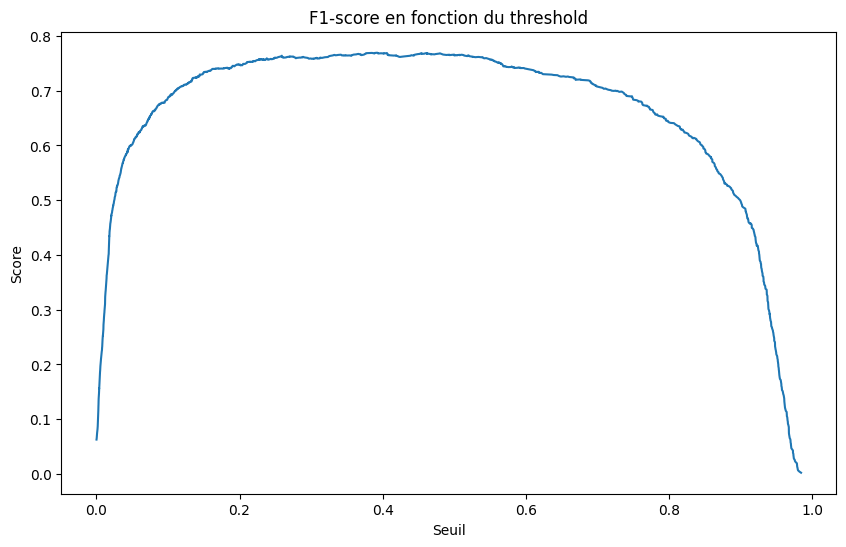

Le seuil optimal pour maximiser le F1-score est : 0.39


In [47]:
# Probabilités de prédiction d'appartenance à la classe positive
y_scores_test = best_model_rf.predict_proba(X_test)[:, 1]

# Precision, recall , seuils
precision, recall, thresholds = precision_recall_curve(y_test, y_scores_test)

# Calcul du F1-score pour chaque seuil
f1_scores = 2 * (precision * recall) / (precision + recall)

# Courbe F1-score en fonction du threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores[:-1], label="F1-score")
plt.xlabel("Seuil")
plt.ylabel("Score")
plt.title("F1-score en fonction du threshold")
plt.show()

# Indice du seuil qui maximise la F1-score
optimal_idx = np.argmax(f1_scores)

# Seuil optimal qui maximise F1-score
optimal_threshold = thresholds[optimal_idx]

print(f"Le seuil optimal pour maximiser le F1-score est : {optimal_threshold:.2f}")

In [48]:
threshold = optimal_threshold

# Prédiction sur les données d'entraînement
y_train_proba = best_model_rf.predict_proba(X_train)[:, 1]
y_train_pred = (y_train_proba >= threshold).astype(int)

# Prédiction sur les données de test
y_test_proba = best_model_rf.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= threshold).astype(int)


# Performance sur l'ensemble d'entraînement
print("Train Accuracy :", accuracy_score(y_train, y_train_pred))
print("Train F1 : ", f1_score(y_train, y_train_pred))
print("Confusion Matrix (Train) :\n", confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))
print()

# Performance sur l'ensemble de test
print("Test Accuracy :", accuracy_score(y_test, y_test_pred))
print("Test F1 : ", f1_score(y_test, y_test_pred))
print("Confusion Matrix (Test) :\n", confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Train Accuracy : 0.9865980877950794
Train F1 :  0.7794990963077717
Confusion Matrix (Train) :
 [[245435   1201]
 [  2215   6038]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    246636
           1       0.83      0.73      0.78      8253

    accuracy                           0.99    254889
   macro avg       0.91      0.86      0.89    254889
weighted avg       0.99      0.99      0.99    254889


Test Accuracy : 0.9860532448273427
Test F1 :  0.7694103911266783
Confusion Matrix (Test) :
 [[27268   137]
 [  258   659]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27405
           1       0.83      0.72      0.77       917

    accuracy                           0.99     28322
   macro avg       0.91      0.86      0.88     28322
weighted avg       0.99      0.99      0.99     28322



In [49]:
# feature_importance
feature_importance = pd.DataFrame(
    index=feature_names,
    data=best_model_rf.feature_importances_,
    columns=["feature_importances"],
)
feature_importance = feature_importance.sort_values(by="feature_importances")
feature_importance

feature_importances
cat__source_Seo                      0.001516
cat__source_Direct                   0.001606
cat__country_Germany                 0.007255
cat__country_UK                      0.010545
cat__country_US                      0.011142
num__age                             0.036613
pass__new_user                       0.042095
num__total_pages_visited             0.889229

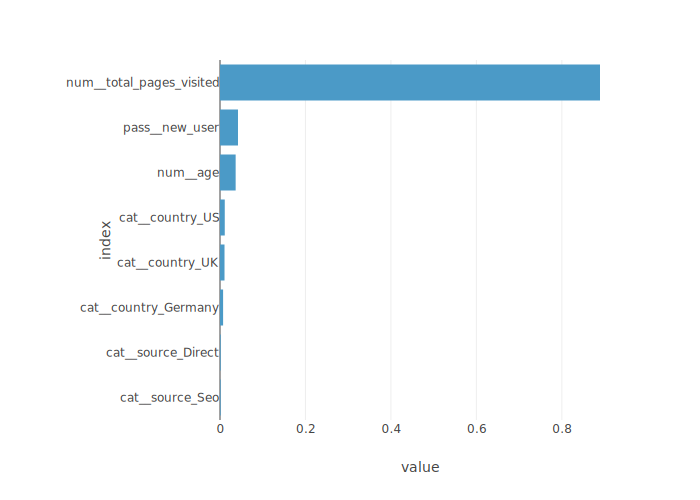

In [50]:
# Plot de feature_importance
fig = px.bar(feature_importance, orientation="h")
fig.update_layout(
    showlegend=False, 
    margin={"l": 220}  
)
fig.show()

In [51]:
score_rf = [{'model': 'RandomForestClassifier', 'f1': f1_score(y_test, y_test_pred)}]
df_scores = pd.concat([df_scores, pd.DataFrame(score_rf)], ignore_index=True)

df_scores

model        f1
0      LogisticRegression  0.774008
1  DecisionTreeClassifier  0.754608
2  RandomForestClassifier  0.769410

## XGBClassifier

In [52]:
xg_model = XGBClassifier()

# Entraînement
xg_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [53]:
# Prédiction
y_test_pred = xg_model.predict(X_test)
y_train_pred = xg_model.predict(X_train)

# Probabilité de prédiction de la classe positive
y_train_proba = xg_model.predict_proba(X_train)[:, 1]  
y_test_proba = xg_model.predict_proba(X_test)[:, 1]  

# Performance sur l'ensemble d'entraînement
print("Train Accuracy :", accuracy_score(y_train, y_train_pred))
print("Train F1 : ", f1_score(y_train, y_train_pred))
print("Confusion Matrix (Train) :\n", confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))
print()

# Performance sur l'ensemble de test
print("Test Accuracy :", accuracy_score(y_test, y_test_pred))
print("Test F1 : ", f1_score(y_test, y_test_pred))
print("Confusion Matrix (Test) :\n", confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Train Accuracy : 0.9867667886805629
Train F1 :  0.774968310094069
Confusion Matrix (Train) :
 [[245708    928]
 [  2445   5808]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    246636
           1       0.86      0.70      0.77      8253

    accuracy                           0.99    254889
   macro avg       0.93      0.85      0.88    254889
weighted avg       0.99      0.99      0.99    254889


Test Accuracy : 0.985594237695078
Test F1 :  0.7524271844660194
Confusion Matrix (Test) :
 [[27294   111]
 [  297   620]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27405
           1       0.85      0.68      0.75       917

    accuracy                           0.99     28322
   macro avg       0.92      0.84      0.87     28322
weighted avg       0.98      0.99      0.98     28322



In [54]:
param_grid = {
    'n_estimators': [100, 300], # nb arbres
    'learning_rate': [0.05, 0.1], # taux d'apprentissage
    'max_depth': [3, 5, 9],
    'min_child_weight': [1, 3],  # complexité de l’arbre
    'gamma': [1, 2],  # paramètre de régularisation
}

In [55]:
grid_search = GridSearchCV(
    estimator=xg_model,
    param_grid=param_grid,
    scoring='f1',       
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Meilleurs paramètres
print()
print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("Meilleur score F1 :", grid_search.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits

Meilleurs hyperparamètres : {'gamma': 1, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300}
Meilleur score F1 : 0.763457906924373


In [56]:
# Meilleur modèle
best_model_xg = grid_search.best_estimator_

# Prédictions
y_train_pred = best_model_xg.predict(X_train)
y_test_pred = best_model_xg.predict(X_test)

# Probabilité de prédiction de la classe positive
y_train_proba = best_model_xg.predict_proba(X_train)[:, 1]  
y_test_proba = best_model_xg.predict_proba(X_test)[:, 1]  

# Performance sur l'ensemble d'entraînement
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Train F1 : ", f1_score(y_train, y_train_pred))
print("Confusion Matrix (Train):\n", confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))


# Performance sur l'ensemble de test
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test F1 : ", f1_score(y_test, y_test_pred))
print("Confusion Matrix (Test):\n", confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Train Accuracy: 0.986237146365673
Train F1 :  0.7655707030205827
Confusion Matrix (Train):
 [[245653    983]
 [  2525   5728]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    246636
           1       0.85      0.69      0.77      8253

    accuracy                           0.99    254889
   macro avg       0.92      0.85      0.88    254889
weighted avg       0.99      0.99      0.99    254889

Test Accuracy: 0.9864416354777205
Test F1 :  0.7681159420289855
Confusion Matrix (Test):
 [[27302   103]
 [  281   636]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27405
           1       0.86      0.69      0.77       917

    accuracy                           0.99     28322
   macro avg       0.93      0.84      0.88     28322
weighted avg       0.99      0.99      0.99     28322



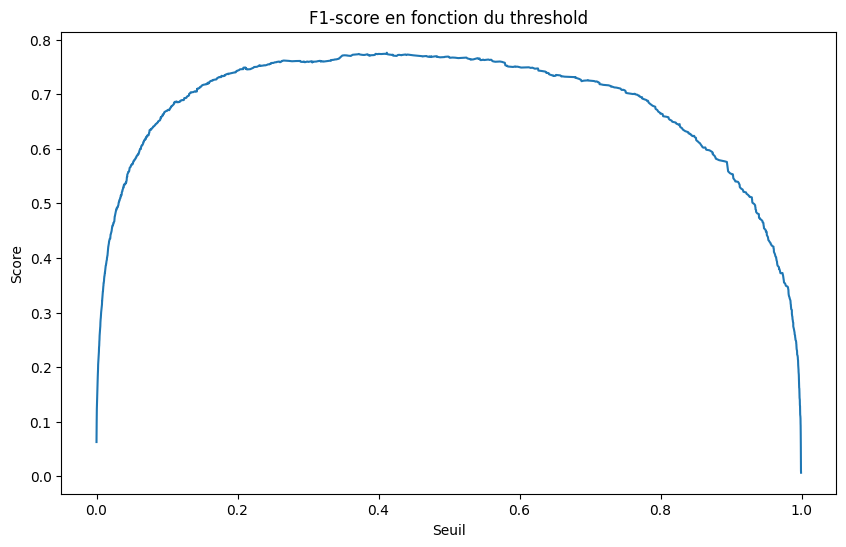

Le seuil optimal pour maximiser le F1-score est : 0.41


In [58]:
# Probabilités de prédiction d'appartenance à la classe positive
y_scores_test = best_model_xg.predict_proba(X_test)[:, 1]

# Precision, recall , seuils
precision, recall, thresholds = precision_recall_curve(y_test, y_scores_test)

# Calcul du F1-score pour chaque seuil
f1_scores = 2 * (precision * recall) / (precision + recall)

# Courbe F1-score en fonction du threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores[:-1], label="F1-score")
plt.xlabel("Seuil")
plt.ylabel("Score")
plt.title("F1-score en fonction du threshold")
plt.show()

# Indice du seuil qui maximise la F1-score
optimal_idx = np.argmax(f1_scores)

# Seuil optimal qui maximise F1-score
optimal_threshold = thresholds[optimal_idx]

print(f"Le seuil optimal pour maximiser le F1-score est : {optimal_threshold:.2f}")

In [59]:
threshold = optimal_threshold

# Prédiction sur les données d'entraînement
y_train_proba = best_model_xg.predict_proba(X_train)[:, 1]
y_train_pred = (y_train_proba >= threshold).astype(int)

# Prédiction sur les données de test
y_test_proba = best_model_xg.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= threshold).astype(int)


# Performance sur l'ensemble d'entraînement
print("Train Accuracy :", accuracy_score(y_train, y_train_pred))
print("Train F1 : ", f1_score(y_train, y_train_pred))
print("Confusion Matrix (Train) :\n", confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))
print()

# Performance sur l'ensemble de test
print("Test Accuracy :", accuracy_score(y_test, y_test_pred))
print("Test F1 : ", f1_score(y_test, y_test_pred))
print("Confusion Matrix (Test) :\n", confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Train Accuracy : 0.9858840514890795
Train F1 :  0.7699782636491497
Confusion Matrix (Train) :
 [[245269   1367]
 [  2231   6022]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    246636
           1       0.81      0.73      0.77      8253

    accuracy                           0.99    254889
   macro avg       0.90      0.86      0.88    254889
weighted avg       0.99      0.99      0.99    254889


Test Accuracy : 0.9863357107548902
Test F1 :  0.7759119861030689
Confusion Matrix (Test) :
 [[27265   140]
 [  247   670]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     27405
           1       0.83      0.73      0.78       917

    accuracy                           0.99     28322
   macro avg       0.91      0.86      0.88     28322
weighted avg       0.99      0.99      0.99     28322



In [60]:
# feature_importance
feature_importance = pd.DataFrame(
    index=feature_names,
    data=best_model_xg.feature_importances_,
    columns=["feature_importances"],
)
feature_importance = feature_importance.sort_values(by="feature_importances")
feature_importance

feature_importances
cat__source_Seo                      0.002402
cat__source_Direct                   0.005942
num__age                             0.029814
cat__country_UK                      0.049617
cat__country_Germany                 0.075256
cat__country_US                      0.078426
pass__new_user                       0.096307
num__total_pages_visited             0.662236

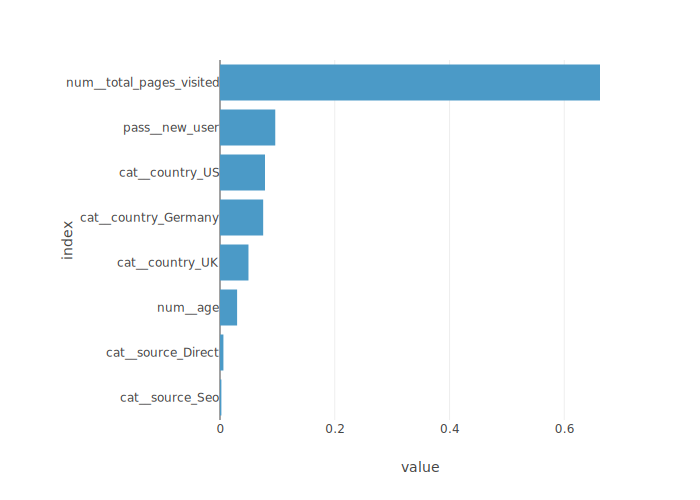

In [61]:
# Plot de feature_importance
fig = px.bar(feature_importance, orientation="h")
fig.update_layout(
    showlegend=False, 
    margin={"l": 220}  
)
fig.show()

In [62]:
score_xg = [{'model': 'XGBClassifier', 'f1': f1_score(y_test, y_test_pred)}]
df_scores = pd.concat([df_scores, pd.DataFrame(score_xg)], ignore_index=True)

df_scores

model        f1
0      LogisticRegression  0.774008
1  DecisionTreeClassifier  0.754608
2  RandomForestClassifier  0.769410
3           XGBClassifier  0.775912